In [ ]:
import torch
import onnx
import onnxruntime as ort
import numpy as np
import math
import time
import gzip
import psutil
import gc

In [8]:
# Function to read IDX format files
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        # Read magic number and dimensions
        magic = int.from_bytes(f.read(4), 'big')
        ndim = magic & 0xFF
        dims = [int.from_bytes(f.read(4), 'big') for _ in range(ndim)]
        
        # Read data
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(dims)

# Load MNIST test data and labels from gz files
mnist_test_images = read_idx('./data/MNIST/raw/t10k-images-idx3-ubyte.gz')
mnist_test_labels = read_idx('./data/MNIST/raw/t10k-labels-idx1-ubyte.gz')

# Preprocess the images: normalize to [0,1] and add channel dimension
mnist_test_images = mnist_test_images.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
mnist_test_labels = mnist_test_labels.astype(np.int64)

print(f"Test images shape: {mnist_test_images.shape}, Test labels shape: {mnist_test_labels.shape}")

# Load the ONNX model
onnx_model_path = './mnist_model.onnx'
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("ONNX model loaded and checked successfully.")

Test images shape: (10000, 1, 28, 28), Test labels shape: (10000,)
ONNX model loaded and checked successfully.


In [9]:
# Create ONNX Runtime session
ort_session = ort.InferenceSession(onnx_model_path)

# Get input details
input_name = ort_session.get_inputs()[0].name
print(f"Input name: {input_name}")
print(f"Input shape: {ort_session.get_inputs()[0].shape}")

# Select a single test image for inference (you can change the index)
test_image_idx = 0
single_image = mnist_test_images[test_image_idx:test_image_idx+1]  # Keep batch dimension
true_label = mnist_test_labels[test_image_idx]

print(f"Single image shape: {single_image.shape}")
print(f"True label: {true_label}")

# Run inference on single image
ort_outputs = ort_session.run(None, {input_name: single_image})
# Get predictions
predictions = np.array(ort_outputs[0])

Input name: input
Input shape: ['batch_size', 1, 28, 28]
Single image shape: (1, 1, 28, 28)
True label: 7


In [10]:
# Convert logits to probabilities using softmax
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return exp_x / np.sum(exp_x)

# Apply softmax to get proper probabilities
probabilities = softmax(predictions[0])
predicted_class_softmax = np.argmax(probabilities)
confidence_softmax = np.max(probabilities)

print(f"After softmax conversion:")
print(f"Predicted class: {predicted_class_softmax}")
print(f"Confidence: {confidence_softmax:.4f}")
print(f"Correct prediction: {predicted_class_softmax == true_label}")

print("\nClass probabilities (after softmax):")
for i, prob in enumerate(probabilities):
    print(f"Class {i}: {prob:.4f}")


After softmax conversion:
Predicted class: 7
Confidence: 1.0000
Correct prediction: True

Class probabilities (after softmax):
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 1.0000
Class 8: 0.0000
Class 9: 0.0000


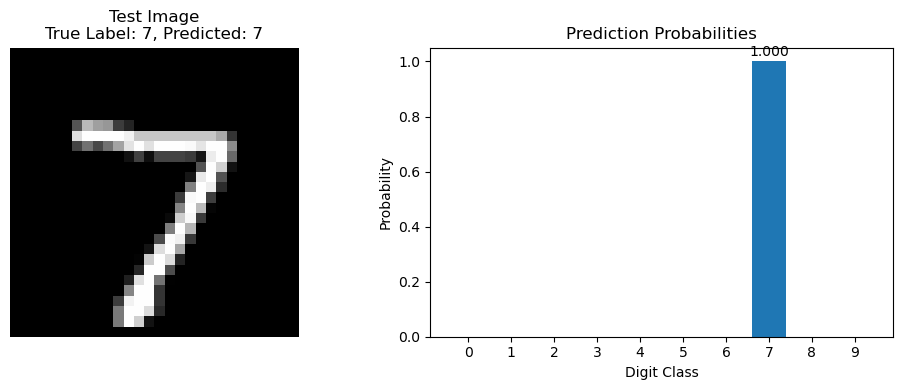

In [11]:
# Visualize the test image and prediction
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Show the image
plt.subplot(1, 2, 1)
plt.imshow(single_image[0, 0], cmap='gray')
plt.title(f'Test Image\nTrue Label: {true_label}, Predicted: {predicted_class_softmax}')
plt.axis('off')

# Show probability distribution
plt.subplot(1, 2, 2)
plt.bar(range(10), probabilities)
plt.xlabel('Digit Class')
plt.ylabel('Probability')
plt.title('Prediction Probabilities')
plt.xticks(range(10))
for i, prob in enumerate(probabilities):
    if prob > 0.01:  # Only show labels for probabilities > 1%
        plt.text(i, prob + 0.01, f'{prob:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# Batch inference on multiple test images
def run_batch_inference(start_idx=0, num_images=100):
    correct_predictions = 0
    all_predictions = []
    
    for i in range(start_idx, min(start_idx + num_images, len(mnist_test_images))):
        # Get single image
        test_image = mnist_test_images[i:i+1]
        true_label = mnist_test_labels[i]
        
        # Run inference
        ort_outputs = ort_session.run(None, {input_name: test_image})
        logits = ort_outputs[0]
        
        # Convert to probabilities
        probabilities = softmax(logits[0])
        predicted_class = np.argmax(probabilities)
        
        all_predictions.append(predicted_class)
        
        if predicted_class == true_label:
            correct_predictions += 1
    
    accuracy = correct_predictions / num_images
    return accuracy, all_predictions

# Test on first 100 images
print("Running batch inference on 100 test images...")
accuracy, predictions = run_batch_inference(0, 100)
print(f"Accuracy on 100 test images: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Test on first 1000 images for more comprehensive evaluation
print("\nRunning batch inference on 1000 test images...")
accuracy_1k, predictions_1k = run_batch_inference(0, 1000)
print(f"Accuracy on 1000 test images: {accuracy_1k:.4f} ({accuracy_1k*100:.2f}%)")

Running batch inference on 100 test images...
Accuracy on 100 test images: 1.0000 (100.00%)

Running batch inference on 1000 test images...
Accuracy on 1000 test images: 0.9920 (99.20%)


In [87]:
# Compare Inference time between ONNX format and pth format
# Load the PyTorch model (CPU only)
pth_model_path = './mnist_model.pth'
pth_model = torch.load(pth_model_path, map_location='cpu')
pth_model.eval()

# Function to run inference, measure time and memory usage (CPU only)
def measure_inference_time(model, input_data, framework='onnx'):
    start_time = time.time()
    if framework == 'onnx':
        logits = model.run(None, {input_name: input_data})[0]
    else:  # pytorch
        with torch.no_grad():
            logits = model(torch.from_numpy(input_data)).numpy()
    end_time = time.time()    
    return (end_time - start_time) * 1000, logits

# Measure ONNX inference time
onnx_time, onnx_logits = measure_inference_time(model=ort_session, input_data=single_image, framework='onnx')
onnx_probabilities = softmax(onnx_logits[0])
onnx_predicted_class = np.argmax(onnx_probabilities)
onnx_confidence = np.max(onnx_probabilities)
print(f"\nONNX Inference Time: {onnx_time*1000:.2f} ms")
print(f"ONNX Predicted class: {onnx_predicted_class}, Confidence: {onnx_confidence:.4f}\n")

# Measure PyTorch inference time
pytorch_time, pytorch_logits = measure_inference_time(model=pth_model, input_data=single_image, framework='pytorch')
pytorch_probabilities = softmax(pytorch_logits[0])
pytorch_predicted_class = np.argmax(pytorch_probabilities)
pytorch_confidence = np.max(pytorch_probabilities)
print(f"PyTorch Inference Time: {pytorch_time*1000:.2f} ms")
print(f"PyTorch Predicted class: {pytorch_predicted_class}, Confidence: {pytorch_confidence:.4f}")


ONNX Inference Time: 0.00 ms
ONNX Predicted class: 7, Confidence: 1.0000

PyTorch Inference Time: 8034.94 ms
PyTorch Predicted class: 7, Confidence: 1.0000
